In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model



In [7]:
import os
os.getcwd()

'c:\\SelfDrive\\RL'

In [8]:
# Assuming you have a pre-existing model
original_model = load_model('C:\SelfDrive\GPS with Vision\GPS_Visual_Model_SpinV2')



In [9]:
original_model.layers

In [12]:
desired_layer_output  = original_model.get_layer('max_pooling2d_2').output

In [18]:
desired_layer_output.shape

TensorShape([None, 22, 40, 64])

In [19]:


# Create a new model that takes the input of the original model
# and outputs the output of the desired layer
model_to_save = Model(inputs=original_model.input, outputs=desired_layer_output)

# Save the new model
model_to_save.save('model_saved_from_CNN.h5')

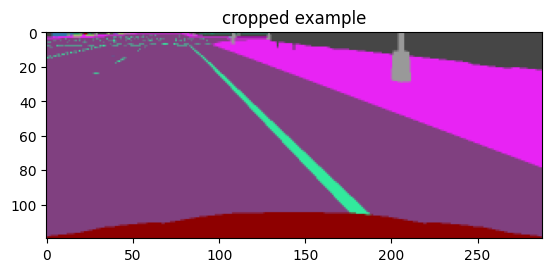

In [2]:
# working how to use cv2 for image loading and cropping
import cv2
from matplotlib import pyplot as plt #to show images in this notebook

HEIGHT = 240
WIDTH = 320

HEIGHT_REQUIRED_PORTION = 0.5 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.9

#using one example only
img_path = 'C:/SelfDrive/GPS with Vision/_img/1688370322528440800_-1_-45.0.png'
image = cv2.imread(img_path)#,cv2.IMREAD_GRAYSCALE)

# resize to a smaller starting size before cropping
image = cv2.resize(image, (WIDTH,HEIGHT))

#calaculate crop param's to take bottom centre part of images focusing on road and lane markings
height_from = int(image.shape[0] * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((image.shape[1] - image.shape[1] * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * image.shape[1])

# this version adds taking lower side of the image
image = image[height_from:,width_from:width_to]
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('cropped example')
plt.show()

In [11]:
image.shape

(120, 288)

In [2]:
# this is to view the image in real colours as plt messes colours up a bit
cv2.imshow('cropped image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
# need to calculate shape from width height
# resize (WIDTH,HEIGHT) starting point
#calaculate crop param's to take bottom centre part of images focusing on road and lane markings
height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

new_height = HEIGHT - height_from
new_width = width_to - width_from

print(new_height, new_width)

120 288


In [19]:
'''
copied from GPS with vision - training a CNN model on existing images

the plan is then to take CNN layer from the saved model after it is trained
and use that as a pre-processing layer for images before going to RL
'''
# building custom generator to process image in batches when training
# this avoids loading all images into RAM at once and stalling the process

import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

from keras.preprocessing.image import ImageDataGenerator


SOURCE_IMG_HIGHT = 480
SOURCE_IMG_WIDTH = 640

HEIGHT = 240
WIDTH = 320

HEIGHT_REQUIRED_PORTION = 0.5 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.9

MAX_STEER_DEGREES = 40
# Define the path to your image data directory
data_dir = 'C:/SelfDrive/GPS with Vision/_img'

#image re-size and crop calcs
height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

new_height = HEIGHT - height_from
new_width = width_to - width_from

# Define the parameters for image preprocessing and augmentation
batch_size = 32
image_size = (new_width,new_height)


# Define the position of the label in the image file name
label_position = -5  # Assuming the label is the fifth character from the end

# Create a custom data generator
def custom_data_generator(image_files, batch_size):
    num_samples = len(image_files)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []
        batch_input_2 = []
        batch_labels = []
        for idx in indices:
            image_path = image_files[idx]
            label = float(os.path.basename(image_path).split('.png')[0].split('_')[2])
            if label > MAX_STEER_DEGREES:
                label = MAX_STEER_DEGREES
            elif label < -MAX_STEER_DEGREES:
                label = -MAX_STEER_DEGREES
            label = float(label)/MAX_STEER_DEGREES
            input_2 = int(os.path.basename(image_path).split('.png')[0].split('_')[1])
            image = preprocess_image(image_path)
            batch_images.append(image)
            batch_input_2.append(input_2)
            batch_labels.append(label)
        yield [np.array(batch_images), np.array(batch_input_2)], np.array(batch_labels)

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # resize to a smaller starting size before cropping
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    #cropping application to take lower side of the image
    image = image[height_from:,width_from:width_to]
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image
#def preprocess_image(image_path):
#    image = keras.preprocessing.image.load_img(image_path, target_size=image_size)
#    image = keras.preprocessing.image.img_to_array(image)
#    image = image / 255.0  # Normalize pixel values between 0 and 1
#    return image


def create_model():
    # Image input
    image_input = Input(shape=(new_height, new_width, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dense(128, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    output = Dense(1, activation='linear')(concatenated_inputs)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model



# Get a list of image file paths and labels
image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.png')]

random.shuffle(image_files)

# Split the data into training and validation sets
split_index = int(len(image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = image_files[:split_index], image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = create_model()
model.summary()
model.compile(loss='MSE',
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=15,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

# Save the trained model
model.save("GPS_Visual_Model_SpinV3_for_RL", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 288, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 60, 144, 64)  0           ['conv2d[0][0]']                 
                                                                                              

INFO:tensorflow:Assets written to: GPS_Visual_Model_SpinV3_for_RL\assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_SpinV3_for_RL\assets


In [47]:
'''
training a CNN model on existing images for RL as above but tweaking model

less epochs - 10
smaller convolutional layers

'''
# building custom generator to process image in batches when training
# this avoids loading all images into RAM at once and stalling the process

import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

from keras.preprocessing.image import ImageDataGenerator


SOURCE_IMG_HIGHT = 480
SOURCE_IMG_WIDTH = 640

# scaled down image size before cropping
HEIGHT = 240
WIDTH = 320

HEIGHT_REQUIRED_PORTION = 0.5 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.9

MAX_STEER_DEGREES = 40
# Define the path to your image data directory
data_dir = 'C:/SelfDrive/GPS with Vision/_img'

#image re-size and crop calcs
height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

# image size into model
new_height = HEIGHT - height_from
new_width = width_to - width_from

# Define the parameters for image preprocessing and augmentation
batch_size = 64
image_size = (new_width,new_height)


# Define the position of the label in the image file name
label_position = -5  # Assuming the label is the fifth character from the end

# Create a custom data generator
def custom_data_generator(image_files, batch_size):
    num_samples = len(image_files)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []
        batch_input_2 = []
        batch_labels = []
        for idx in indices:
            image_path = image_files[idx]
            label = float(os.path.basename(image_path).split('.png')[0].split('_')[2])
            if label > MAX_STEER_DEGREES:
                label = MAX_STEER_DEGREES
            elif label < -MAX_STEER_DEGREES:
                label = -MAX_STEER_DEGREES
            label = float(label)/MAX_STEER_DEGREES
            input_2 = int(os.path.basename(image_path).split('.png')[0].split('_')[1])
            image = preprocess_image(image_path)
            batch_images.append(image)
            batch_input_2.append(input_2)
            batch_labels.append(label)
        yield [np.array(batch_images), np.array(batch_input_2)], np.array(batch_labels)

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # resize to a smaller starting size before cropping
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    #cropping application to take lower side of the image
    image = image[height_from:,width_from:width_to]
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image


def create_model():
    # Image input
    image_input = Input(shape=(new_height, new_width, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dense(8, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    output = Dense(1, activation='linear')(concatenated_inputs)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model



# Get a list of image file paths and labels
image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.png')]

random.shuffle(image_files)

# Split the data into training and validation sets
split_index = int(len(image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = image_files[:split_index], image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = create_model()
model.summary()
model.compile(loss='MSE',
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=10,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

# Save the trained model
model.save("GPS_Visual_Model_SpinV4_for_RL", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 120, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_90 (Conv2D)             (None, 120, 288, 64  6976        ['input_57[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_90 (MaxPooling2D  (None, 60, 144, 64)  0          ['conv2d_90[0][0]']              
 )                                                                                         

INFO:tensorflow:Assets written to: GPS_Visual_Model_SpinV4_for_RL\assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_SpinV4_for_RL\assets


In [52]:
#This is what actually saves the model to be used in RL training
desired_layer_output  = model.get_layer('dense_33').output
model_to_save = Model(inputs=model.input, outputs=desired_layer_output)

# Save the new model
model_to_save.save('model_saved_from_CNN.h5')

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np

cnn_model = load_model('model_saved_from_CNN.h5',compile=False)
cnn_model.compile()

img = np.float32(image)
img = img /255
img = np.expand_dims(img, axis=0)
cnn_applied = cnn_model([img,0],training=False)
cnn_applied = np.squeeze(cnn_applied)
cnn_applied.shape

(7, 18, 8)

In [6]:
cnn_applied[4][9]

array([0.        , 0.        , 0.        , 0.        , 0.3504135 ,
       0.16477773, 0.        , 0.        ], dtype=float32)

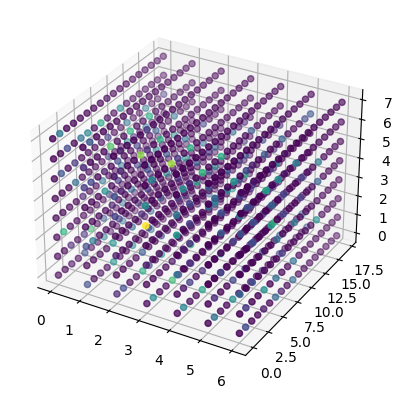

In [7]:
# visualise 3d array
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a small 3D NumPy array
data = cnn_applied

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the shape of the array
x, y, z = data.shape

# Create a 3D grid of coordinates
x, y, z = np.meshgrid(np.arange(x), np.arange(y), np.arange(z))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()

# Flatten the array data
data = data.flatten()

# Create a 3D scatter plot
ax.scatter(x, y, z, c=data, cmap='viridis')

# Show the plot
plt.show()

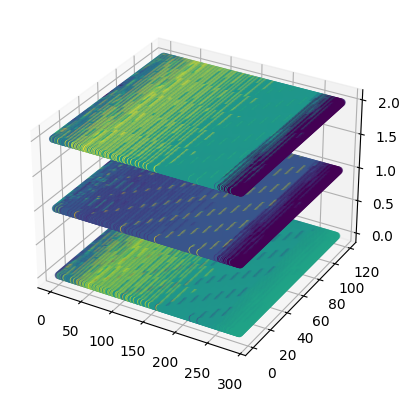

In [10]:
# visualise 3d array for original image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a small 3D NumPy array
data = image

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the shape of the array
x, y, z = data.shape

# Create a 3D grid of coordinates
x, y, z = np.meshgrid(np.arange(x), np.arange(y), np.arange(z))

# Flatten the arrays for plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()

# Flatten the array data
data = data.flatten()

# Create a 3D scatter plot
ax.scatter(y, x, z, c=data, cmap='viridis')

# Show the plot
plt.show()

In [27]:
# this is to check the spin after spawning - found that need to pause for 2 seconds after spawning
import carla
import random
import time

client = carla.Client('localhost', 2000)
time.sleep(5)
client.set_timeout(25)
world = client.get_world()
spawn_points = world.get_map().get_spawn_points()

vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
time.sleep(2)
angle_adj = random.randrange(-10, 10, 1)
trans = vehicle.get_transform()

spectator = world.get_spectator()
spectator_pos = carla.Transform(start_point.location + carla.Location(x=20,y=10,z=4),
                                carla.Rotation(yaw = start_point.rotation.yaw -155))
spectator.set_transform(spectator_pos)

trans.rotation.yaw = trans.rotation.yaw + angle_adj
vehicle.set_transform(trans)
print('angele applied',angle_adj)

angele applied -2


In [20]:
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

In [21]:
trans = vehicle.get_transform()

In [22]:
print(trans)

Transform(Location(x=-64.644844, y=24.471010, z=0.001712), Rotation(pitch=0.000000, yaw=0.159198, roll=0.000000))


In [23]:
trans.rotation.yaw = trans.rotation.yaw + angle_adj

In [24]:
print(trans)

Transform(Location(x=-64.644844, y=24.471010, z=0.001712), Rotation(pitch=0.000000, yaw=9.159198, roll=0.000000))


In [25]:
vehicle.set_transform(trans)

In [28]:
for actor in world.get_actors().filter('*vehicle*'):
	actor.destroy()

In [1]:
# this is to get spectator to follow the car
import carla
import random
import time

client = carla.Client('localhost', 2000)
time.sleep(5)
client.set_timeout(25)
world = client.get_world()
for actor in world.get_actors().filter('*vehicle*'):
	actor.destroy()
spawn_points = world.get_map().get_spawn_points()

vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
time.sleep(2)
trans = vehicle.get_transform()





In [12]:
spectator = world.get_spectator()
spectator_pos = carla.Transform(start_point.location + carla.Location(x=20,y=10,z=4),
                                carla.Rotation(yaw = start_point.rotation.yaw -155))
spectator.set_transform(spectator_pos)

In [13]:
print(trans.location)

Location(x=225.252029, y=-364.109375, z=0.001572)


In [20]:
spectator_pos = carla.Transform(trans.location + carla.Location(x=0,y=0,z=30),
                                carla.Rotation(pitch = trans.rotation.pitch -90))
spectator.set_transform(spectator_pos)

In [2]:
client.load_world('Town05')

In [1]:
'''
trying to flatten the layer for visualisation

'''
# building custom generator to process image in batches when training
# this avoids loading all images into RAM at once and stalling the process

import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

from keras.preprocessing.image import ImageDataGenerator


SOURCE_IMG_HIGHT = 480
SOURCE_IMG_WIDTH = 640

# scaled down image size before cropping
HEIGHT = 240
WIDTH = 320

HEIGHT_REQUIRED_PORTION = 0.5 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.9

MAX_STEER_DEGREES = 40
# Define the path to your image data directory
data_dir = 'C:/SelfDrive/GPS with Vision/_img'

#image re-size and crop calcs
height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

# image size into model
new_height = HEIGHT - height_from
new_width = width_to - width_from

# Define the parameters for image preprocessing and augmentation
batch_size = 64
image_size = (new_width,new_height)


# Define the position of the label in the image file name
label_position = -5  # Assuming the label is the fifth character from the end

# Create a custom data generator
def custom_data_generator(image_files, batch_size):
    num_samples = len(image_files)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []
        batch_input_2 = []
        batch_labels = []
        for idx in indices:
            image_path = image_files[idx]
            label = float(os.path.basename(image_path).split('.png')[0].split('_')[2])
            if label > MAX_STEER_DEGREES:
                label = MAX_STEER_DEGREES
            elif label < -MAX_STEER_DEGREES:
                label = -MAX_STEER_DEGREES
            label = float(label)/MAX_STEER_DEGREES
            input_2 = int(os.path.basename(image_path).split('.png')[0].split('_')[1])
            image = preprocess_image(image_path)
            batch_images.append(image)
            batch_input_2.append(input_2)
            batch_labels.append(label)
        yield [np.array(batch_images), np.array(batch_input_2)], np.array(batch_labels)

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # resize to a smaller starting size before cropping
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    #cropping application to take lower side of the image
    image = image[height_from:,width_from:width_to]
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image


def create_model():
    # Image input
    image_input = Input(shape=(new_height, new_width, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(6, 6), activation='relu',padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dense(1, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    output = Dense(1, activation='linear')(concatenated_inputs)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model



# Get a list of image file paths and labels
image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.png')]

random.shuffle(image_files)

# Split the data into training and validation sets
split_index = int(len(image_files) * 0.8)  # 80% for training, 20% for validation
train_files, val_files = image_files[:split_index], image_files[split_index:]

# Create data generators for training and validation
train_generator = custom_data_generator(train_files, batch_size)
val_generator = custom_data_generator(val_files, batch_size)

model = create_model()
model.summary()
model.compile(loss='MSE',
              optimizer='adam')

# Train the model
model.fit(train_generator, steps_per_epoch=len(train_files) // batch_size, epochs=10,
          validation_data=val_generator, validation_steps=len(val_files) // batch_size)

# Save the trained model
model.save("GPS_Visual_Model_Play", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 288, 64  6976        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 60, 144, 64)  0           ['conv2d[0][0]']                 
                                                                                              

KeyboardInterrupt: 

Extracted word: VIC


'3030'

Address does not match the expected format.
